# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

---
## 2. Load data

In [2]:
client_df = pd.read_csv("../data/client_data.csv", parse_dates=["date_activ", "date_end", "date_modif_prod", "date_renewal"])

In [3]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv("../data/price_data.csv")
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index() 

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


We make the following adjustments to the feature to try to improve the predictive power of the feature:
- Drop all rows with prices equal to 0 (probably erroneous data)
- Make sure to use actual January and December prices are used (not available for all ids)
- Instead of absolute price changes we use relative price changes to account for scale effects

In [6]:
# Drop all rows with prices which are 0
price_df = price_df[(price_df["price_off_peak_var"] > 0) & (price_df["price_off_peak_fix"] > 0)]

# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Make sure that January and December data is available
monthly_price_by_id["month"] = monthly_price_by_id["price_date"].dt.month
monthly_price_by_id = monthly_price_by_id[monthly_price_by_id["month"].isin([1, 12])]
monthly_price_by_id = monthly_price_by_id.sort_values(["id", "month"])
monthly_price_by_id = monthly_price_by_id.groupby("id").filter(lambda x: len(x) == 2)

# Get January and December prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index() 

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_rel_diff_dec_january_energy'] = (diff['dec_1'] - diff['price_off_peak_var']) / diff['price_off_peak_var']
diff['offpeak_rel_diff_dec_january_power'] = (diff['dec_2'] - diff['price_off_peak_fix']) / diff['price_off_peak_fix']
feature_df = diff[['id', 'offpeak_rel_diff_dec_january_energy','offpeak_rel_diff_dec_january_power']]
feature_df.head()

,id,offpeak_rel_diff_dec_january_energy,offpeak_rel_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.049105,4.016066e-03
1,0004351ebdd665e6ee664792efc4fd13,-0.027721,4.016063e-03
2,0010bcc39e42b3c2131ed2ce55246e3c,0.334421,3.374980e-02
3,0010ee3855fdea87602a5b7aba8e42de,-0.081390,4.016066e-03
4,00114d74e963e47177db89bc70108537,-0.026728,-2.710827e-08


### Additional Features

- We add additional features that seemed promising in the previous explanatory data analysis
- One advantage of using random forests is that they are not distance based, so normalization of numerical attributes is not necessary
- We can also use label encoding instead of one hot encoding to encode categorical features

In [7]:
def diff_month (d1, d2):
    """Returns the difference between two dates in months."""
    return(d1.year - d2.year) * 12 + d1.month - d2.month

In [8]:
# we add price volatility as a feature because more frequent price changes could increase the likelihood of churn
price_vola = price_df[["id", "price_off_peak_var", "price_off_peak_fix"]].groupby("id").std().reset_index()
price_vola = price_vola.rename(columns={"price_off_peak_var": "price_vola_var", "price_off_peak_fix": "price_vola_fix"})
feature_df = feature_df.merge(price_vola)

# sales channel, note: 25% of values are missing and encoded as class MISSING
feature_df = feature_df.merge(client_df[["id", "channel_sales"]])
feature_df["channel_sales"] = feature_df["channel_sales"].astype("category").cat.codes # label encoding

# gas client
feature_df = feature_df.merge(client_df[["id", "has_gas"]])
feature_df["has_gas"] = feature_df["has_gas"].astype("category").cat.codes # label encoding

# first campaign
feature_df = feature_df.merge(client_df[["id", "origin_up"]])
feature_df["origin_up"] = feature_df["origin_up"].astype("category").cat.codes # label encoding

# consumption data
feature_df = feature_df.merge(client_df[["id", "cons_12m", "cons_gas_12m", "cons_last_month", "imp_cons", "pow_max"]])

# dates
client_df["months_tenure"] = client_df.apply(lambda row: diff_month(row["date_end"], row["date_activ"]), axis=1)
client_df["months_last_modif"] = client_df.apply(lambda row: diff_month(pd.to_datetime("2016-01-31"), row["date_modif_prod"]), axis=1)
client_df["months_last_renewal"] = client_df.apply(lambda row: diff_month(pd.to_datetime("2016-01-31"), row["date_renewal"]), axis=1)
feature_df = feature_df.merge(client_df[["id", "months_tenure", "months_last_modif", "months_last_renewal"]])
feature_df = feature_df.merge(client_df[["id", "num_years_antig"]])

# forecast data
# We do not use forecast_price_energy_peak as feature since the previous analysis has shown that many prices are 0
# meaning the price date is probably erroneous
feature_df = feature_df.merge(client_df[["id", "forecast_cons_12m", "forecast_cons_year", "forecast_discount_energy", 
                                           "forecast_meter_rent_12m", "forecast_price_energy_off_peak", 
                                           "forecast_price_pow_off_peak"]])

# margin data
feature_df = feature_df.merge(client_df[["id", "margin_gross_pow_ele", "margin_net_pow_ele", "net_margin"]])

# active products
feature_df = feature_df.merge(client_df[["id", "nb_prod_act"]])

### Feature Selection
#### Multicolinearity
- Normally, we would check for multicolinearity, e.g., using the *Variance Inflation Factor (VIF)* to remove highly correlated features
- For random forests, this step is not necessary
- When one of several correlated features is used as a split attribute, the importance of the others is simply reduced
- However, this can bias the model feature importances, although this effect is somewhat reduced by random selection of features

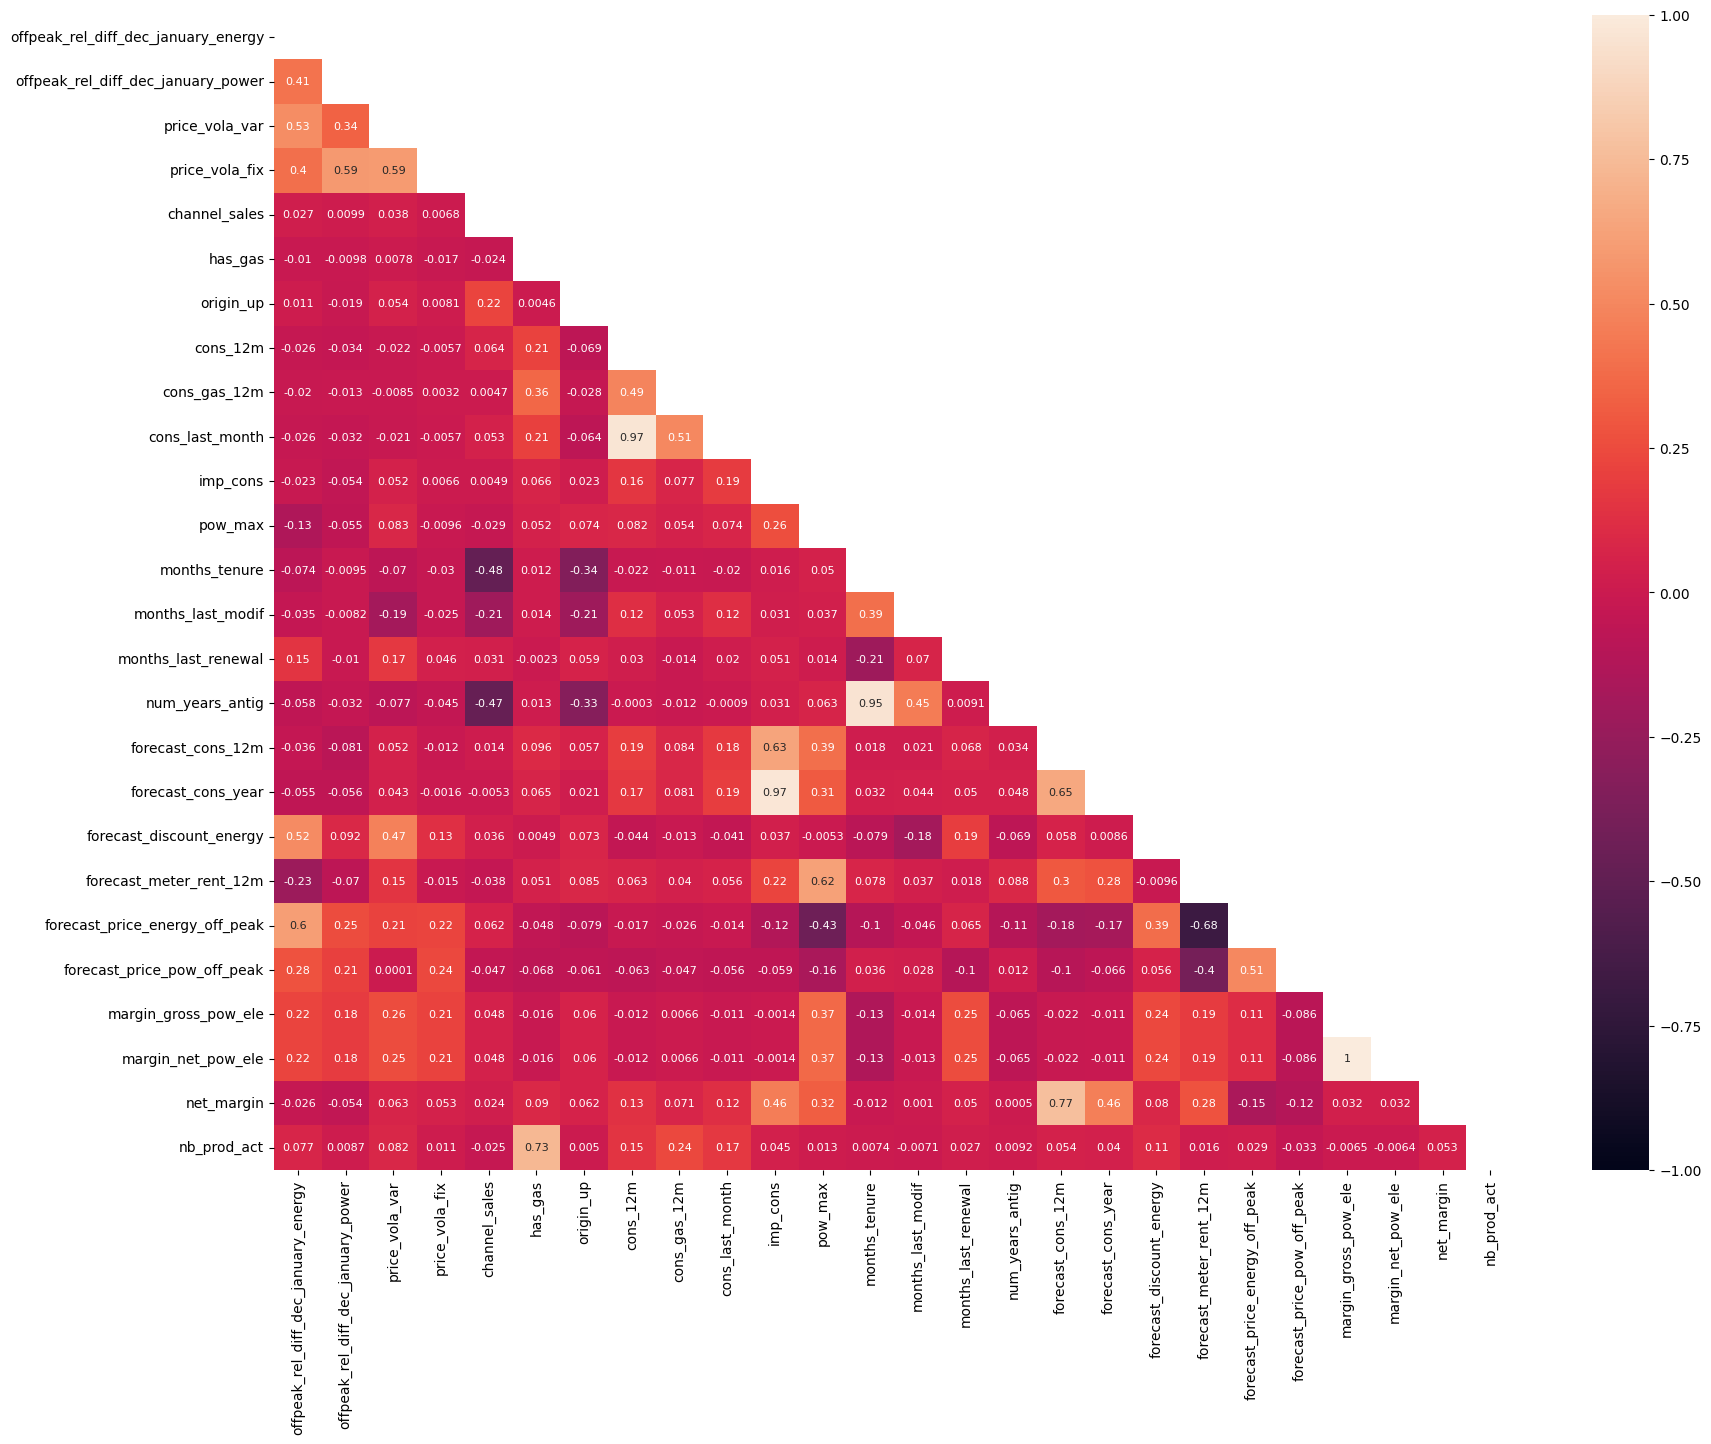

In [9]:
plt.figure(figsize=(20, 15))
corr_matrix = feature_df.corr(numeric_only=True).round(4)
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 8}, vmin=-1, vmax=1, mask=np.triu(corr_matrix))
plt.show()

- We see that some features are highly correlated, such as customer age and tenure
- In addition, we could use a random forest for feature selection (e.g., https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) to remove low importance features
- In this case it would be important to not train the feature selection model on data also used for evaluation, for meaningful evaluation

## Model Evaluation
- For demonstration purposes, we use a simple train test split
- A more sophisticated evaluation approach for an imbalanced dataset would be cross-validation with stratified sampling to preserve the percentage 
of samples for each class (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
- We use the default parameters of the model, in addition we could do hyperparameter tuning to improve model performance (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
### Evaluation Metrics
- We use ***precision*** and ***recall*** as evaluation metrics
- Recall in particular is important because it is affected by false negatives, which are the worst case in our scenario
    - False Negative: A churning customer is predicted as non-churning, which would cause the most financial damage as all future revenue would be lost
    - False Positive: A customer who did not churn is predicted to churn, this would mean offering a discount to a customer who would also pay full price, this is less financial damage than losing the customer
- Alternatively we could use F1-score which is the harmonic mean of precision and recall
- Accuracy is not a suitable metric because the data set is imbalanced 

In [10]:
# add target variable
df = feature_df.merge(client_df[["id", "churn"]])
feature_names = feature_df.columns[1:].to_list()

# split dataset
X = df[feature_names]#.to_numpy()
y = df["churn"]#.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_pred_probas = clf.predict_proba(x_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9086    0.9973    0.9509      2611
           1     0.7500    0.0742    0.1350       283

    accuracy                         0.9070      2894
   macro avg     0.8293    0.5358    0.5430      2894
weighted avg     0.8931    0.9070    0.8711      2894



- The results show that the model is able to predict churn to some extent (high recall and precision for class 1, decent precision for class 1)
- The low recall for class 1 (churn) is concerning because it means that the model often incorrectly predicts class 0 (no churn) for actual churning customers
- The high accuracy of 90% is not meaningful because we have a strong class imbalance

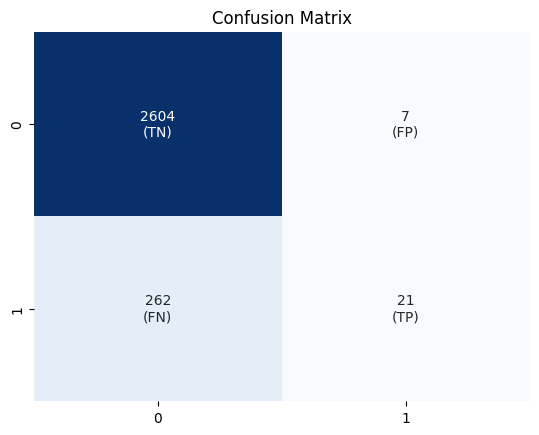

In [11]:
# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, ["TN","FP","FN","TP"])]
labels = np.array(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.show()

- As recall indicated we have a high number of false negatives (262)
- Further steps would be to focus on reducing the number of false negatives and improving recall

## Feature Importances

- An advantage of random forests is that they provide features importances
- They can be used to gain insight into which features are most important in predicting churn
- These insights are especially important to increase understanding and trust when the model is used in actual business decisions

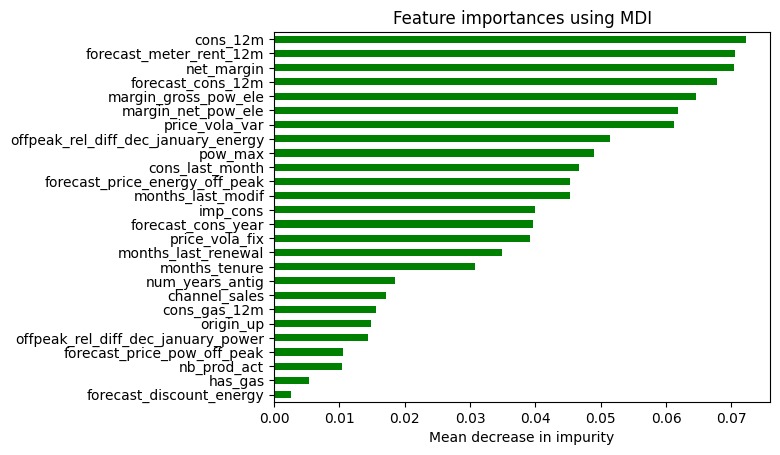

In [12]:
importances = pd.Series(clf.feature_importances_, index=feature_names)
importances.sort_values().plot(kind="barh", color="green")
plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity")
plt.show()

- According to the model features electricity consumption of the past 12 months, total net margin and forcasted meter rent & consumption are the strongest predictors of churn
- Price sensitivity features have varying feature importance, but do not appear to be the strongest predictor
- However, impurity-based feature importances can be misleading for high cardinality features, permutation feature importance can be used as alternative (https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

In [13]:
# save predictions
df_test_predictions = x_test.copy()
df_test_predictions["churn"] = y_test
df_test_predictions["churn_prediction"] = y_pred
df_test_predictions["churn_proba"] = y_pred_probas[:,1]
df_test_predictions.to_csv("test_predictions.csv", index=False)